# Feature engineering
------------------------------

This example shows how to use automated feature generation to improve your model's performance.

The data used is a variation on the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The goal of this dataset is to predict whether or not it will rain tomorrow training a binay classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv('./datasets/weatherAUS.csv')

# Let's have a look at a subset of the data
X.sample(frac=1).iloc[:5, :8]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed
36171,WaggaWagga,14.3,21.4,0.8,10.6,5.8,W,52.0
44425,Canberra,16.0,22.8,0.0,12.4,6.0,E,50.0
126238,Walpole,13.8,20.7,4.8,NaN,NaN,NW,33.0
54550,Ballarat,3.3,14.7,0.0,NaN,NaN,N,46.0
85638,Cairns,23.5,31.5,43.8,0.8,8.5,SSE,52.0


## Run the pipeline

In [3]:
# Initiate ATOM and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0, random_state=1)
atom.impute(strat_num='knn', strat_cat='remove', min_frac_rows=0.8)
atom.encode(max_onehot=10, frac_to_other=0.04)

# Let's see how a LightGBM model performs without adding additional features
atom.run('LGB', metric='auc')
atom.scoring()

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Results ===================== >>
LightGBM --> roc_auc: 0.878


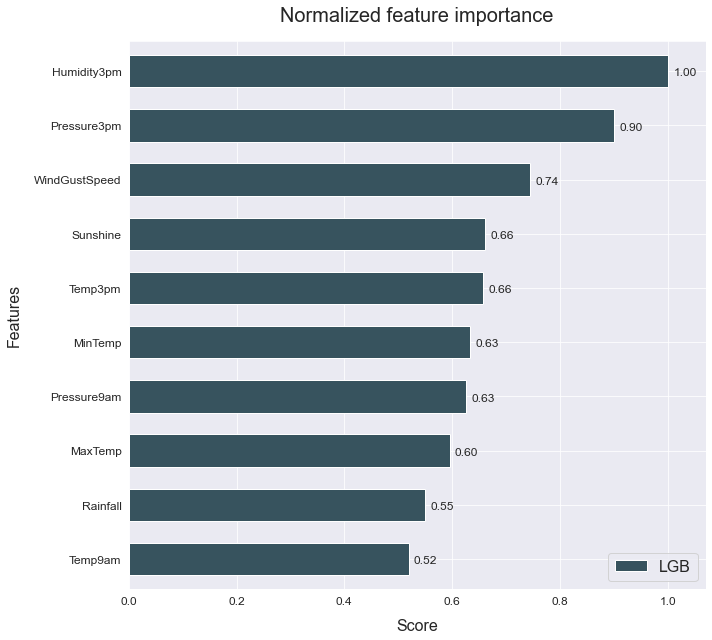

In [4]:
# What are the most important fetaures?
atom.plot_feature_importance(show=10)

**Now let's create some new fetaures using Deep Feature Synthesis**

In [5]:
atom.verbose = 2  # Increase verbosity to see the output

# Create 100 new features using DFS
atom.feature_generation(strategy='dfs', n_features=100, operators=['add', 'sub', 'log', 'sqrt'])

Fitting FeatureGenerator...
Creating new features...
 --> 100 new features were added to the dataset.


divide by zero encountered in log
invalid value encountered in log


In [6]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the missing attribute
atom.missing

# We can easily turn off warnings in the future
atom.warnings = False

In [7]:
# We can use the impute method again
atom.impute(strat_num='knn', strat_cat='remove', min_frac_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Imputing 577 missing values using the KNN imputer in feature LOG(Cloud9am).
 --> Dropping feature LOG(RainToday_other) for containing 8873 (99%) missing values.
 --> Imputing 148 missing values using the KNN imputer in feature LOG(Sunshine).
 --> Imputing 6 missing values using the KNN imputer in feature LOG(Temp9am).
 --> Imputing 33 missing values using the KNN imputer in feature LOG(WindSpeed3pm).


In [8]:
# 100 new features may be to much...
# Let's check for multicollinearity and use RFECV to reduce the number even further
atom.feature_selection(strategy='RFECV', solver='lgb', n_features=30, scoring='auc', max_correlation=0.98)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature Location was removed due to low variance. Value 0.2077375946173255 repeated in 100% of the rows.
 --> Feature Cloud3pm + Humidity3pm was removed due to collinearity with another feature.
 --> Feature Cloud3pm + RainToday_No was removed due to collinearity with another feature.
 --> Feature Cloud3pm + WindDir9am was removed due to collinearity with another feature.
 --> Feature Cloud3pm - Location was removed due to collinearity with another feature.
 --> Feature Cloud3pm - RainToday_No was removed due to collinearity with another feature.
 --> Feature Cloud9am + WindGustDir was removed due to collinearity with another feature.
 --> Feature Evaporation + Location was removed due to collinearity with another feature.
 --> Feature Evaporation + WindGustDir was removed due to collinearity with another feature.
 --> Feature Evaporation - WindDir3pm was removed due to collinearity with another feature.
 --> Feature Humi

In [9]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

,drop_feature,correlated_feature,correlation_value
0,Cloud3pm + Humidity3pm,Humidity3pm,0.99578
1,Cloud3pm + RainToday_No,Cloud3pm,0.98122
2,Cloud3pm + WindDir9am,"Cloud3pm, Cloud3pm + RainToday_No","0.99968, 0.98054"
3,Cloud3pm - Location,"Cloud3pm, Cloud3pm + RainToday_No, Cloud3pm + ...","1.0, 0.98122, 0.99968"
4,Cloud3pm - RainToday_No,"Cloud3pm, Cloud3pm + WindDir9am, Cloud3pm - Lo...","0.98405, 0.98408, 0.98405"
5,Cloud9am + WindGustDir,Cloud9am,0.99979
6,Evaporation + Location,Evaporation,1.0
7,Evaporation + WindGustDir,"Evaporation, Evaporation + Location","0.9999, 0.9999"
8,Evaporation - WindDir3pm,"Evaporation, Evaporation + Location, Evaporati...","0.9999, 0.9999, 0.99969"
9,Humidity3pm - RainToday_No,"Humidity3pm, Cloud3pm + Humidity3pm","0.99983, 0.99572"


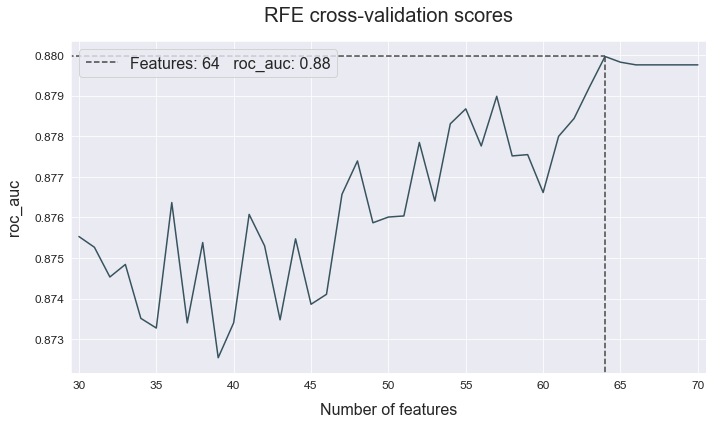

In [10]:
# After applying RFECV, we can plot the score per number of features
atom.plot_rfecv()

In [11]:
# Let's see how the model performs now
atom.run('LGB')


Running pipeline ============================= >>
Models in pipeline: LGB
Metric: roc_auc


Results for LightGBM:         
Fitting -----------------------------------------
Score on the train set --> roc_auc: 0.9962
Score on the test set  --> roc_auc: 0.8787
Time elapsed: 0.708s
-------------------------------------------------
Total time: 0.722s


Final results ========================= >>
Duration: 0.723s
------------------------------------------
LightGBM --> roc_auc: 0.879


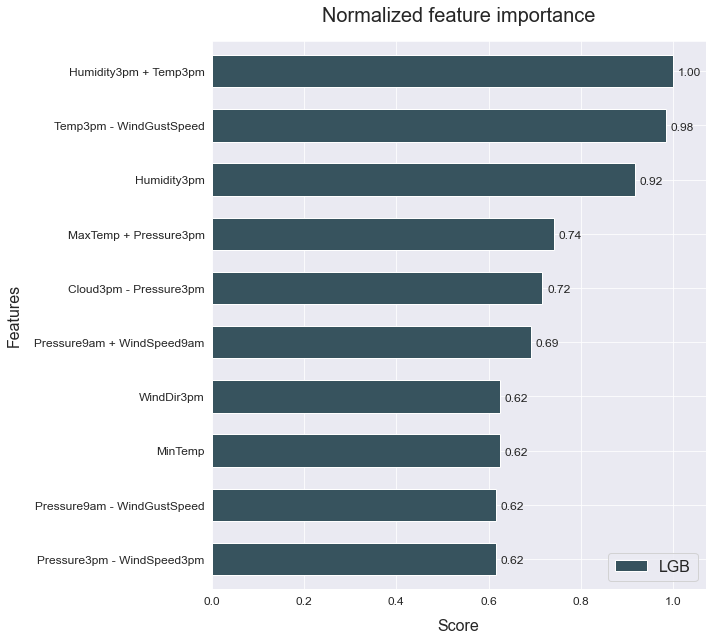

In [12]:
# Did the feature importance change?
atom.plot_feature_importance(show=10)

**Lets try the same using Genetic Feature Generation**

In [13]:
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0, warnings=False, random_state=1)
atom.impute(strat_num='knn', strat_cat='remove', min_frac_rows=0.8)
atom.encode(max_onehot=10, frac_to_other=0.04)

# Change verbosity to print extended info
atom.verbose = 2

# Create new features using Genetic Programming
atom.feature_generation(strategy='genetic', n_features=20, generations=10, population=2000)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.17         0.127531        3          0.50405              N/A      9.52s
   1     3.10         0.338627        5         0.536586              N/A      9.04s
   2     3.50         0.443734        9         0.541692              N/A      7.65s
   3     4.44          0.47684        7          0.54494              N/A      6.89s
   4     6.25         0.512037       13         0.546193              N/A      5.76s
   5     7.47         0.507736        9         0.550266              N/A      4.62s
   6     7.73         0.500405       11          0.55324              N/A      3.56s
   7     7.99         0.497944       11         0.553398              N/A      2.38s
   8     9.29         0.494223       13        

In [14]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features

,name,description,fitness
0,Feature 24,"mul(sub(sub(sub(Humidity3pm, Sunshine), Sunshi...",0.542398
1,Feature 25,"mul(sub(sub(Humidity3pm, Sunshine), Sunshine),...",0.542240
2,Feature 26,"mul(sub(Humidity3pm, Sunshine), mul(sub(sub(Hu...",0.542240
3,Feature 27,"mul(mul(sub(Humidity3pm, Sunshine), WindGustSp...",0.542240
4,Feature 28,"mul(mul(sub(sub(Humidity3pm, Sunshine), Sunshi...",0.542240


In [15]:
# And fit the model again
atom.run('LGB', metric='auc')


Running pipeline ============================= >>
Models in pipeline: LGB
Metric: roc_auc


Results for LightGBM:         
Fitting -----------------------------------------
Score on the train set --> roc_auc: 0.9901
Score on the test set  --> roc_auc: 0.8793
Time elapsed: 0.305s
-------------------------------------------------
Total time: 0.313s


Final results ========================= >>
Duration: 0.314s
------------------------------------------
LightGBM --> roc_auc: 0.879


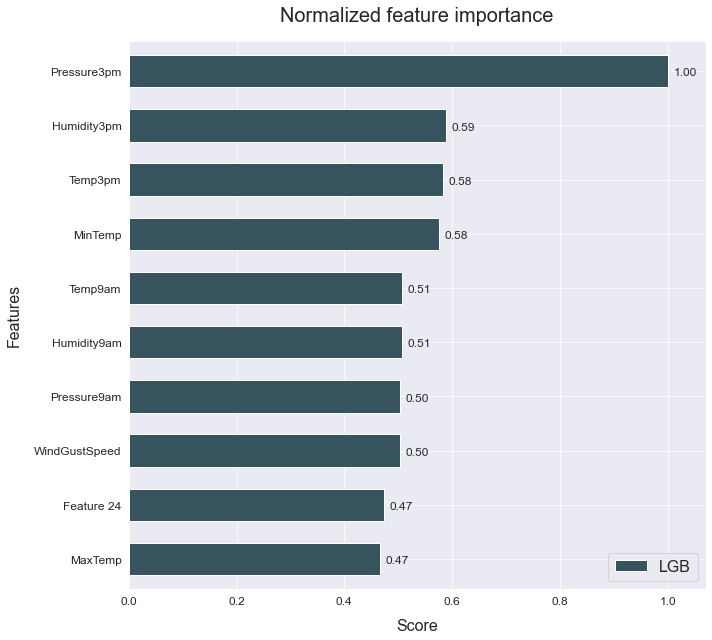

In [16]:
atom.plot_feature_importance(show=10)

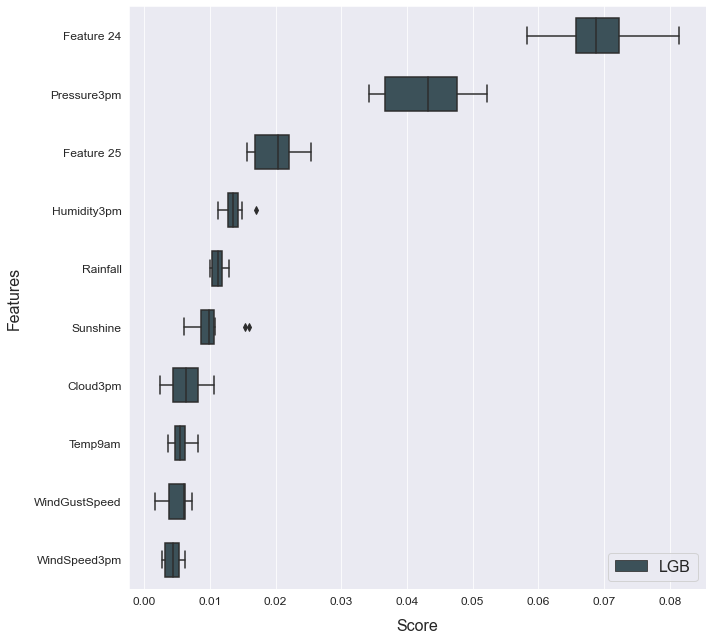

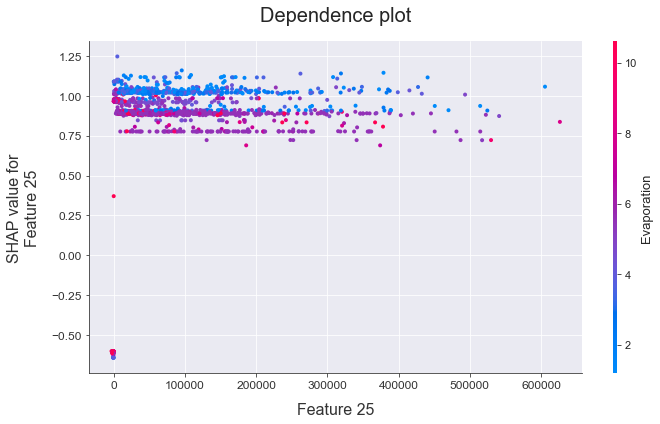

In [17]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(show=10)
atom.dependence_plot()